In [1]:
import pandas as pd
import plotnine as p9
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Helper functions

# Filter to include/exclude 'not provided' rows in series
def filter_notprovided(series, keep=False):
    from numpy import ndarray as nparr
    if keep:
        if type(series.iloc[0]) == nparr:
            return series.map(lambda x: x.tolist() == ['not provided'])
        elif type(series.iloc[0]) == np.int32:
            return series.map(pd.isnull)
        else:
            return series.map(lambda x: x == 'not provided')
    
    if type(series.iloc[0]) == nparr:
        return series.map(lambda x: x.tolist() != ['not provided'])
    elif type(series.iloc[0]) == np.int32:
            return series.map(pd.isnull)
    else:
        return series.map(lambda x: x != 'not provided')

# Length and percentage of df as part of whole df
def len_and_pct(partdf, wholedf):
    pct = f'{round(len(partdf)/float(len(wholedf))*100, 2)}%'
    return (len(partdf), pct)

# Abbreviate words
def abbrev(s):
    import re
    words = s.split()
    shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
    return " ".join(shortened)

# Group by one column, count the values in another, return a dataframe
def count_values(df, groupby, countcol, colname="counts"):
    return df.groupby(groupby)[countcol].value_counts().reset_index(name=colname)

# Replace words with known abbreviations
def shorten(s):
    maps = {
        'unavailable': 'U',
        'degraded performance': 'P',
        'intermittent': 'I',
        'continuous': 'C',
        'visual': 'V',
        'some': 'SU',
        'all': 'AU',
        'single region': 'SR',
        'multiple regions': 'MR',
        'single availability zone': 'AZ',
        'code error': 'CODE',
        'third party': '3P',
        'internal api issue': 'INTCOM',
        'increased load': 'LOAD',
        'internal network issue': 'INTCONN',
        'unhealthy unit': 'UNHLT',
        'configuration error': 'CFG',
        'maintenance side effect': 'MAINT',
        'deployment task': 'DEPLTSK',
        'shock event': 'SHOCK',
        'backend inefficiency': 'BKINEF',
        'environmental conditions': 'ENV',
        'nodes/devices/instances': 'UNIT',
        'external requests (apis)': 'EXTREQ',
        'storage': 'STOR',
        'internal communication interfaces': 'INTREQ',
        'external network/connectivity': 'EXTCONN',
        'processing backend': 'BKPROC',
        'certificates/licenses': 'CERT',
        'internal network': 'INTCONN',
        'user interface': 'UI',
        'everything': 'ALL',
        'one': '1',
        'multiple': '+'
    }
    return maps[s]

# Max-normalize a numerical column, grouping by another column
def max_normalize_by_column(df, by, target):
    max_normalize = lambda series: (series-series.min())/(series.max()-series.min())

    target_normalized = pd.concat([df[df[by] == x][target].pipe(max_normalize) 
                                   for x in df[by].unique().tolist()])

    return df.drop(target, axis='columns').merge(target_normalized, how='left', left_index=True, right_index=True)

def export_graph(graphname, df, columns, plot):
    print('Not provided:')
    for c in columns:
        with open("../report/src/numbers/"+"np-"+graphname+"-"+c+".tex", "w") as f:
            f.write("%d (%s)" % len_and_pct(df[filter_notprovided(df[c], keep=True)], df))
        print(f'- {c}: {"%d (%s)" % len_and_pct(df[filter_notprovided(df[c], keep=True)], df)}')

    plot.save("../report/src/images/"+graphname+".png")
    print(plot)

In [2]:
df = pd.read_parquet("../data/preprocessed.parquet")

# These columns are pointless to plot, and take a long time
df.drop(labels=['description', 'service_id'], axis=1, inplace=True)
df.columns

Index(['affected', 'cause', 'duration', 'duration_min', 'first_notification',
       'half_desc', 'hour_of_week', 'last_notification', 'location', 'monitor',
       'org_type', 'range', 'service_name', 'services', 'severity', 'status',
       'users', 'vendor'],
      dtype='object')

Not provided:
- range: 8 (0.86%)


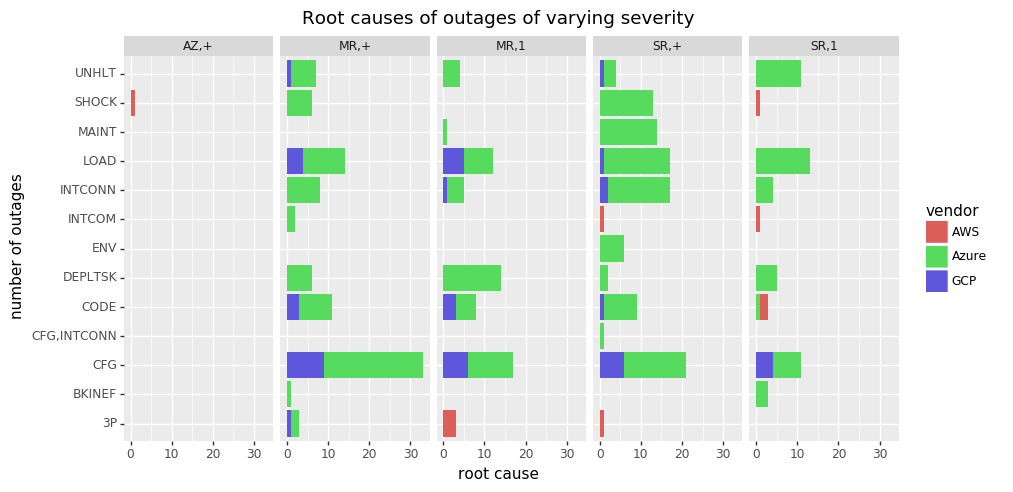

<ggplot: (311335757)>


In [3]:
subdf = df[['range', 'services', 'vendor', 'cause']]
filt = subdf[filter_notprovided(subdf.cause) & filter_notprovided(subdf.range) & filter_notprovided(subdf.services)]
plotdf = pd.DataFrame({'range_services': filt[['range', 'services']].applymap(shorten).agg(','.join, axis=1),
                       'cause': filt.cause.map(lambda x: ','.join(map(shorten, x))),
                       'vendor': filt.vendor})


export_graph("root-causes-by-severity", subdf, ['range'],#, 'services', 'cause'],
             (p9.ggplot(plotdf)
              + p9.aes(x='cause', fill='vendor') 
              + p9.geom_bar()
              + p9.coord_flip()
              + p9.theme(figure_size=(10,5))
              + p9.facet_grid("~ range_services")
              + p9.labs(x="number of outages", y="root cause")
              + p9.ggtitle("Root causes of outages of varying severity")))

In [4]:
scale_x_hours_as_dow = p9.scale_x_continuous(breaks=range(0,24*8, 24), minor_breaks=1, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ''])

Not provided:
- hours: 0 (0.0%)


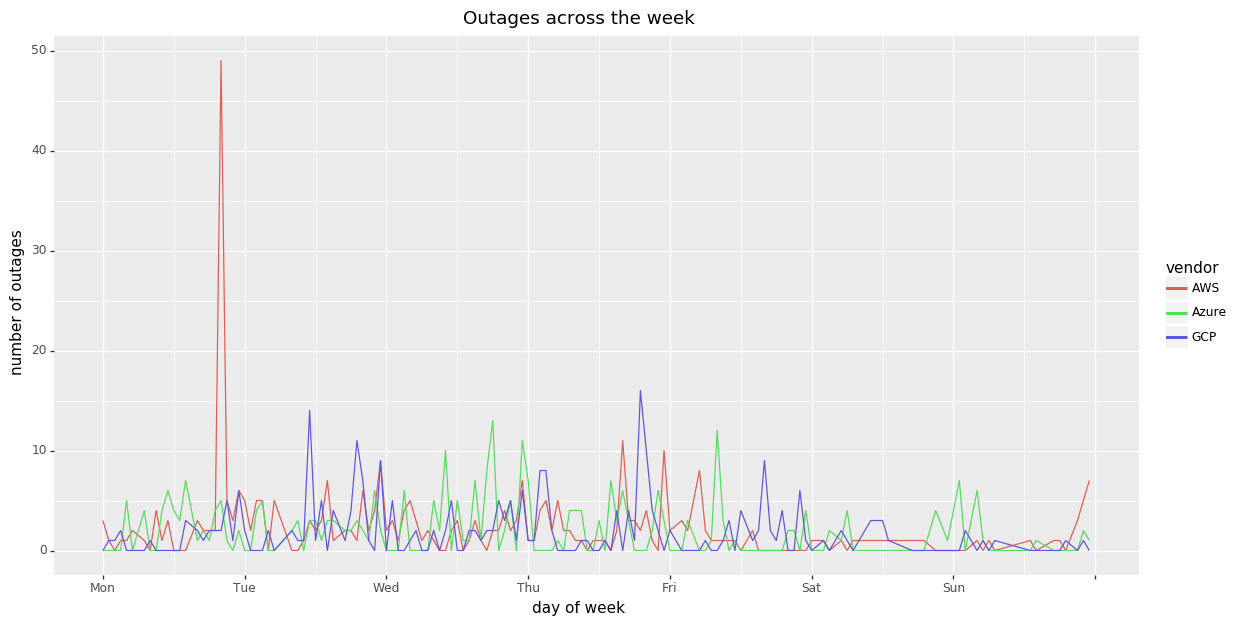

<ggplot: (278505621)>


In [5]:
azure_hours = df[df.vendor == "Azure"].hour_of_week.value_counts()
aws_hours = df[df.vendor == "AWS"].hour_of_week.value_counts()
gcp_hours = df[df.vendor == "GCP"].hour_of_week.value_counts()

plotdf = (pd.DataFrame({'Azure': azure_hours,
                       'GCP': gcp_hours,
                       'AWS': aws_hours})
          .applymap(lambda x: 0 if pd.isna(x) else x)
          .reset_index().rename(columns={"index": "hours"}))

export_graph("outages-across-week", plotdf, ['hours'],
             (p9.ggplot(plotdf.melt(id_vars='hours', var_name='vendor', value_name='outages_count'))
              + p9.aes(x='hours', y='outages_count', color='vendor')
              + p9.geom_line()
              + scale_x_hours_as_dow
              + p9.labs(x='day of week', y='number of outages')
              + p9.theme(figure_size=(14, 7))
              + p9.ggtitle("Outages across the week")))

Not provided:
- affected: 95 (10.23%)
- hour_of_week: 67 (7.21%)


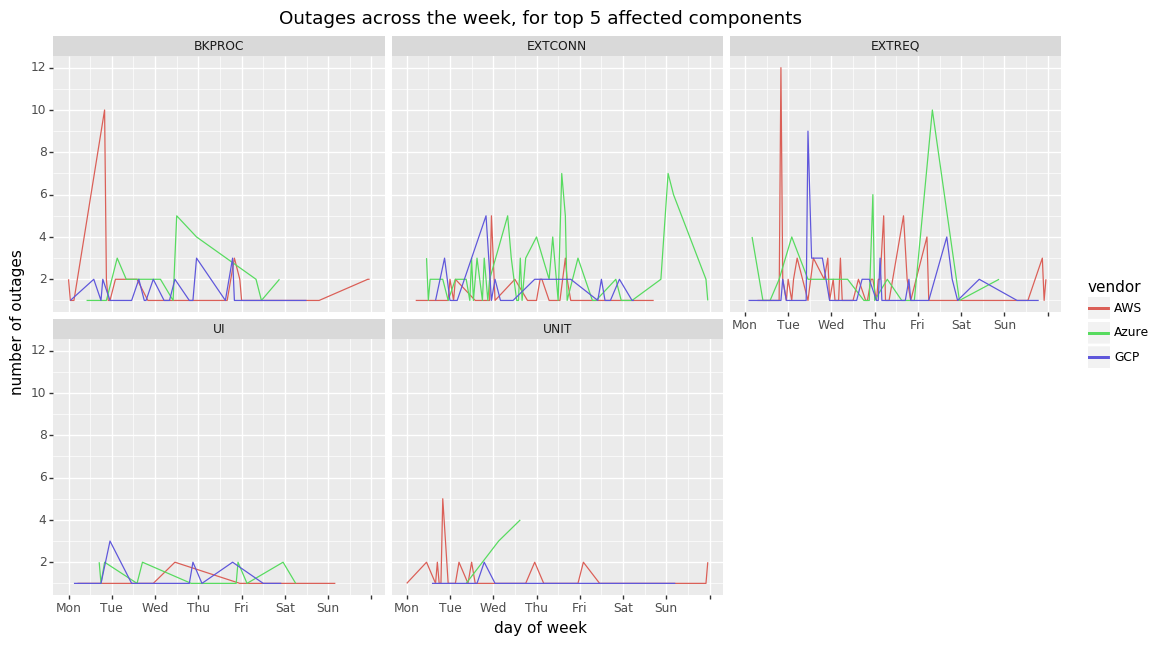

<ggplot: (311329777)>


In [6]:
filt = df[filter_notprovided(df.affected) & df.hour_of_week.notna()]

plotdf = pd.DataFrame({'vendor': filt.vendor,
                       'affected': filt.affected.map(lambda x: ','.join(map(shorten, x))),
                       'hour_of_week': filt.hour_of_week})
top_5_affected = plotdf.affected.value_counts()[0:5].index

plotdf = (plotdf[plotdf.affected.isin(top_5_affected)]
          .melt(id_vars=['vendor', 'affected'], value_name='hour_of_week')
          .drop('variable', axis='columns')
          .groupby(['vendor', 'affected'])
          .hour_of_week.value_counts().reset_index(name='num_outages'))

export_graph("components-across-week", df, ['affected', 'hour_of_week'],
             (p9.ggplot(plotdf)
              + p9.aes(x='hour_of_week', y='num_outages', color='vendor')
              + p9.geom_line()
              + p9.facet_wrap('~affected')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(np.ceil(x[1])), 2))
              + scale_x_hours_as_dow
              + p9.labs(x='day of week', y='number of outages')
              + p9.theme(figure_size=(13,7))
              + p9.ggtitle("Outages across the week, for top 5 affected components")))

In [7]:
type(df.hour_of_week.iloc[0])

numpy.int32

Not provided:
- range: 8 (0.86%)
- severity: 82 (8.83%)
- hour_of_week: 67 (7.21%)


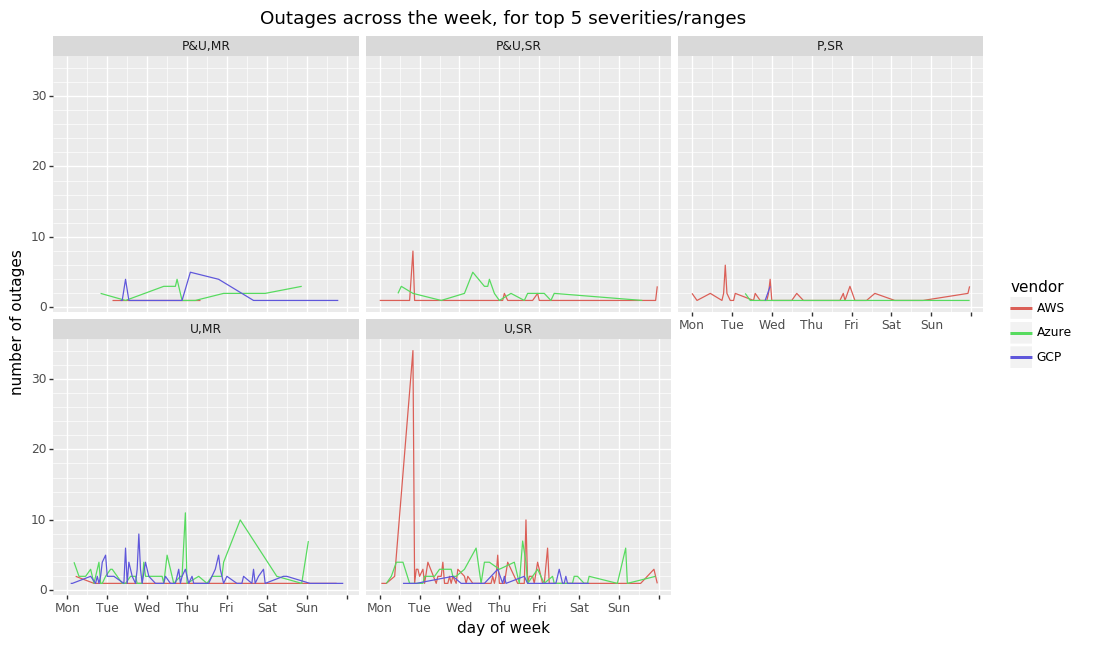

<ggplot: (316167001)>


In [8]:
filt = df[filter_notprovided(df.severity) & filter_notprovided(df.range) & df.hour_of_week.notna()]

plotdf = pd.DataFrame({'vendor': filt.vendor,
                       'severity_range': filt.severity.map(lambda x: '&'.join(map(shorten, x))) + ',' + filt.range.map(shorten),
                       'hour_of_week': filt.hour_of_week})
top_5_severity_range = plotdf.severity_range.value_counts()[0:5].index

plotdf = (plotdf[plotdf.severity_range.isin(top_5_severity_range)]
          .melt(id_vars=['vendor', 'severity_range'], value_name='hour_of_week')
          .drop('variable', axis='columns')
          .groupby(['vendor', 'severity_range'])
          .hour_of_week.value_counts().reset_index(name='num_outages'))

export_graph("severities-ranges-across-week", df, ['range', 'severity', 'hour_of_week'],
             (p9.ggplot(plotdf)
              + p9.aes(x='hour_of_week', y='num_outages', color='vendor')
              + p9.geom_line()
              + p9.facet_wrap('~ severity_range')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(np.ceil(x[1])), 10), minor_breaks=4)
              + scale_x_hours_as_dow
              + p9.labs(x="day of week", y="number of outages")
              + p9.theme(figure_size=(12,7))
              + p9.ggtitle("Outages across the week, for top 5 severities/ranges")))

Not provided:
- cause: 605 (65.12%)
- affected: 95 (10.23%)


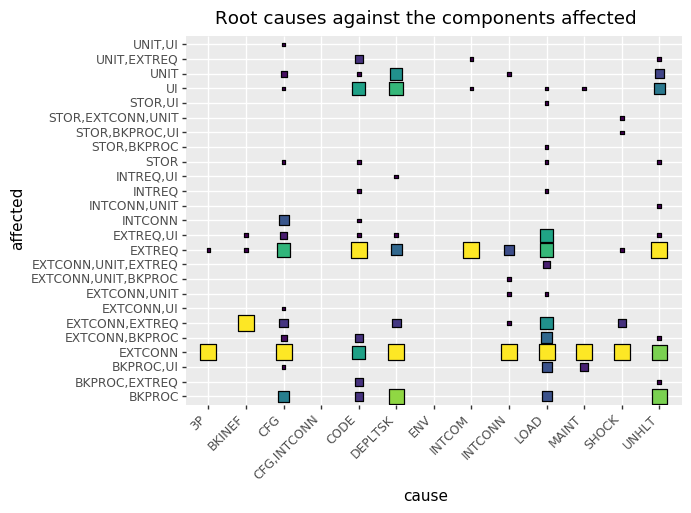

<ggplot: (314469521)>


In [9]:
plotdf = (df[filter_notprovided(df.cause) & filter_notprovided(df.affected)][['cause', 'affected']]
          .applymap(lambda x: ','.join(map(shorten, x)))
          .pipe(count_values, groupby='affected', countcol='cause')
          .pipe(max_normalize_by_column, by='cause', target='counts'))

export_graph("root-causes-components-affected", df, ['cause', 'affected'],
             (p9.ggplot(plotdf)
              + p9.aes(x='cause', y='affected', fill='counts', size='counts')
              + p9.geom_count(show_legend=False, shape='s')
              + p9.ggtitle("Root causes against the components affected")
              + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))))

Not provided:
- severity: 82 (8.83%)
- users: 7 (0.75%)
- duration: 77 (8.29%)


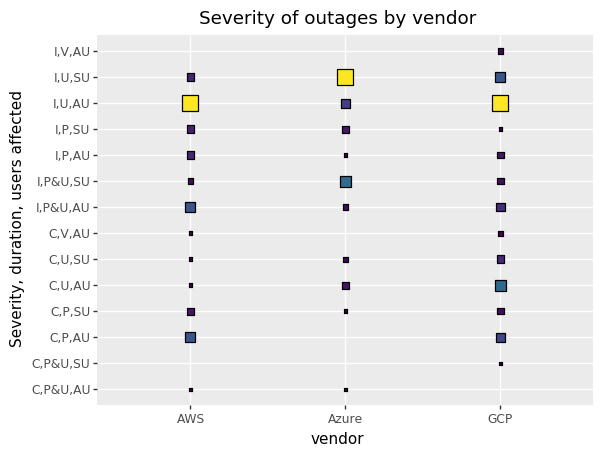

<ggplot: (314064965)>


In [10]:
filt = df[filter_notprovided(df.severity) & filter_notprovided(df.users) & filter_notprovided(df.duration)]
plotdf = (pd.DataFrame({'severity_users_duration': (filt.duration.map(shorten)
                                                   +","+filt.severity.map(lambda x: '&'.join([shorten(y) for y in x]))
                                                   +","+filt.users.map(shorten)),
                         'vendor': filt.vendor})
          .pipe(count_values, groupby='severity_users_duration', countcol='vendor')
          .pipe(max_normalize_by_column, by='vendor', target='counts'))

export_graph("severity-by-vendor", df, ['severity', 'users', 'duration'],
             (p9.ggplot(plotdf)
              + p9.aes(x='vendor', y='severity_users_duration', fill='counts', size='counts')
              + p9.geom_count(show_legend=False, shape='s')
              + p9.ggtitle("Severity of outages by vendor")
              + p9.labs(y="Severity, duration, users affected")))

Not provided:
- affected: 95 (10.23%)


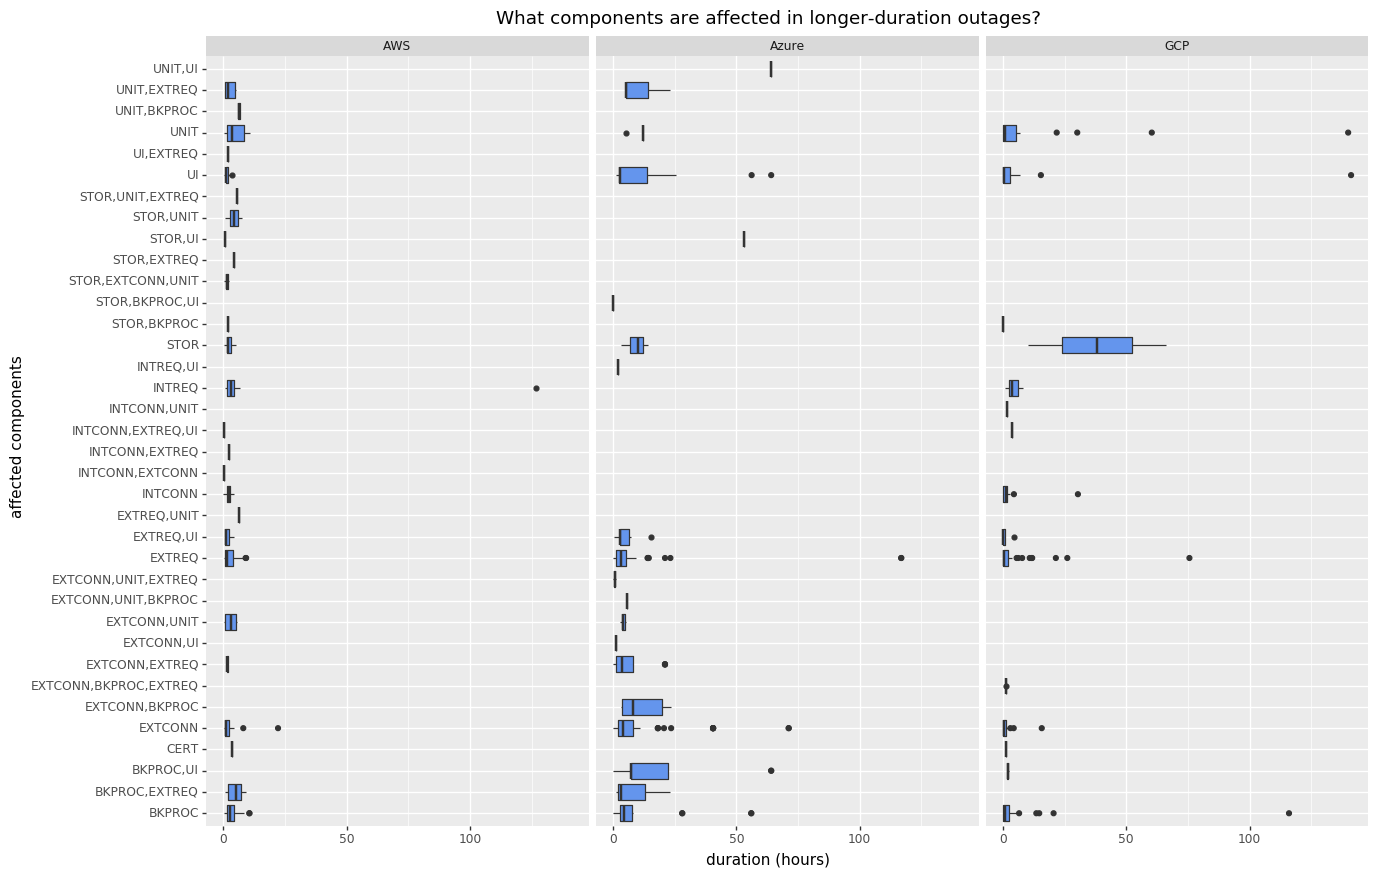

<ggplot: (278529029)>


In [11]:
filtered = df[filter_notprovided(df.affected) & (df.duration_min >= 0)]
plotdf = pd.DataFrame({'affected': filtered.affected.map(lambda x: ','.join(map(shorten, x))),
                       'duration_min': filtered.duration_min,
                       'duration_hr': filtered.duration_min/60.0,
                       'vendor': filtered.vendor})

with open("../report/src/numbers/components-vs-duration-n-wrong-times.tex", "w") as f:
    f.write("%d" % len(df[df.duration_min < 0]))

export_graph("components-vs-duration", df, ['affected'], 
             (p9.ggplot(plotdf.melt(id_vars=['vendor', 'affected'], value_vars=['duration_hr'], value_name='duration_hr'))
              + p9.aes(y='duration_hr', x='affected')
              + p9.geom_boxplot(fill='cornflowerblue')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(x[1]), 50), minor_breaks=1)
              + p9.labs(y="duration (hours)", x="affected components")
              + p9.coord_flip()
              + p9.facet_wrap("~vendor")
              + p9.theme(figure_size=(15,10))
              + p9.ggtitle("What components are affected in longer-duration outages?")))

Not provided:
- cause: 605 (65.12%)


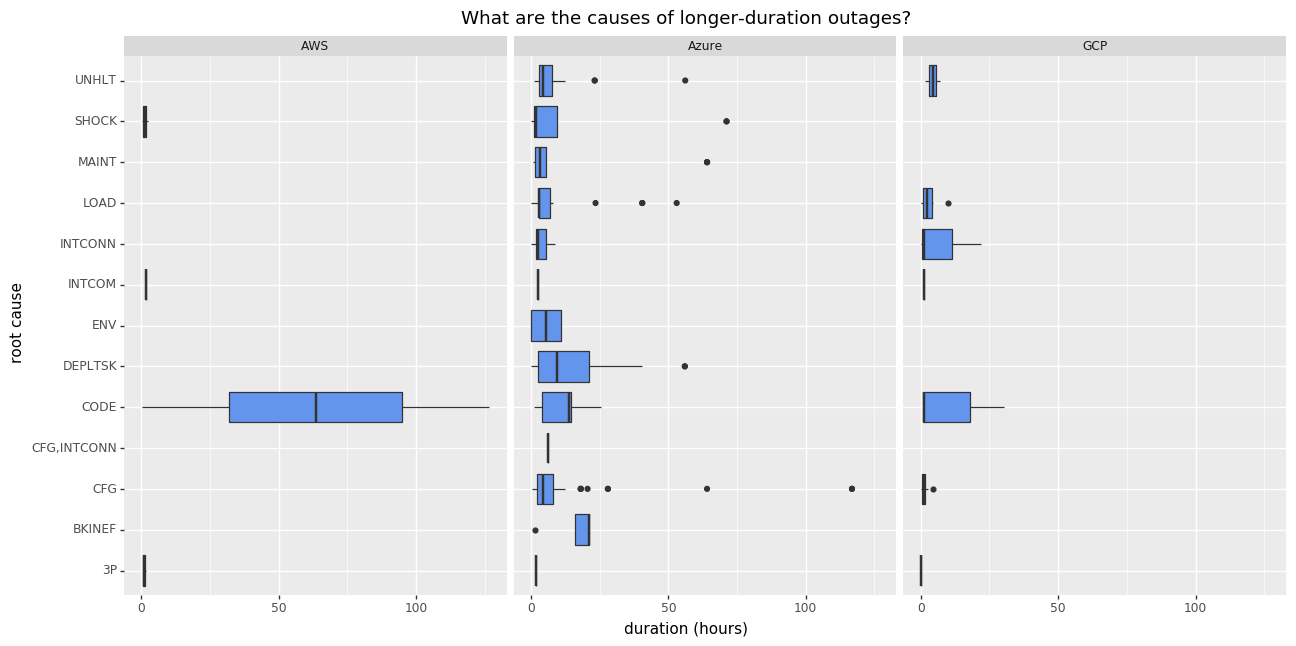

<ggplot: (316441305)>


In [12]:
filtered = df[filter_notprovided(df.cause) & (df.duration_min >= 0)]
plotdf = pd.DataFrame({'cause': filtered.cause.map(lambda x: ','.join(map(shorten, x))),
                       'duration_min': filtered.duration_min,
                       'duration_hr': filtered.duration_min/60.0,
                       'vendor': filtered.vendor})
with open("../report/src/numbers/components-vs-duration-n-wrong-times.tex", "w") as f:
    f.write("%d" % len(df[df.duration_min < 0]))

export_graph("causes-vs-duration", df, ['cause'],
             (p9.ggplot(plotdf.melt(id_vars=['vendor', 'cause'], value_vars=['duration_hr'], value_name='duration_hr'))
              + p9.aes(y='duration_hr', x='cause')
              + p9.geom_boxplot(fill='cornflowerblue')
              + p9.scale_y_continuous(breaks=lambda x: range(0, int(x[1]), 50), minor_breaks=1)
              + p9.labs(y="duration (hours)", x="root cause")
              + p9.coord_flip()
              + p9.facet_wrap("~vendor")
              + p9.theme(figure_size=(15,7))
              + p9.ggtitle("What are the causes of longer-duration outages?")))

Not provided:
- users: 7 (0.75%)
- range: 8 (0.86%)


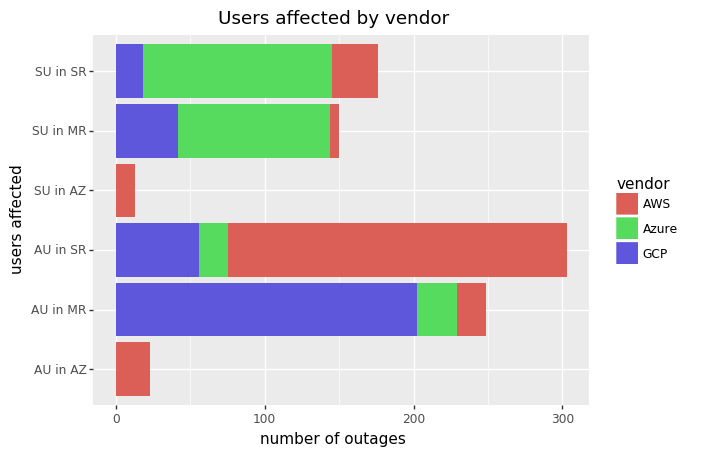

<ggplot: (311613273)>


In [13]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range)]
plotdf = pd.DataFrame({'users_range': filt.users.map(shorten)+' in '+filt.range.map(shorten),
                       'vendor': filt.vendor})
export_graph("users-affected-by-vendor", df, ['users', 'range'],
             (p9.ggplot(plotdf)
              + p9.aes(x='users_range', fill='vendor')
              + p9.geom_bar()
              + p9.labs(x='users affected', y='number of outages')
              + p9.coord_flip()
              + p9.ggtitle("Users affected by vendor")))

Not provided:
- users: 7 (0.75%)
- range: 8 (0.86%)
- severity: 82 (8.83%)
- duration: 77 (8.29%)


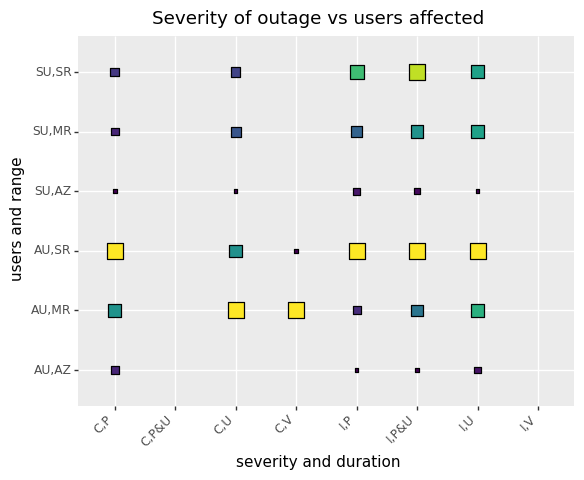

<ggplot: (311660961)>


In [14]:
filt = df[filter_notprovided(df.users) & filter_notprovided(df.range) & filter_notprovided(df.severity) & filter_notprovided(df.duration)]
plotdf = (pd.DataFrame({'users and range': filt.users.map(shorten)+','+filt.range.map(shorten),
                       'severity and duration': (filt.duration.map(shorten)
                                                 +','
                                                 +filt.severity.map(lambda x: '&'.join(map(shorten, x))))})
          .pipe(count_values, groupby='users and range', countcol='severity and duration')
          .pipe(max_normalize_by_column, by='severity and duration', target='counts'))

export_graph("severity-vs-users-affected", df, ['users', 'range', 'severity', 'duration'],
             (p9.ggplot(plotdf)
              + p9.aes(x='severity and duration', y='users and range', fill='counts', size='counts')
              + p9.geom_point(show_legend=False, shape='s')
              + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
              + p9.ggtitle("Severity of outage vs users affected")))

Not provided:
- affected: 95 (10.23%)
- range: 8 (0.86%)
- users: 7 (0.75%)


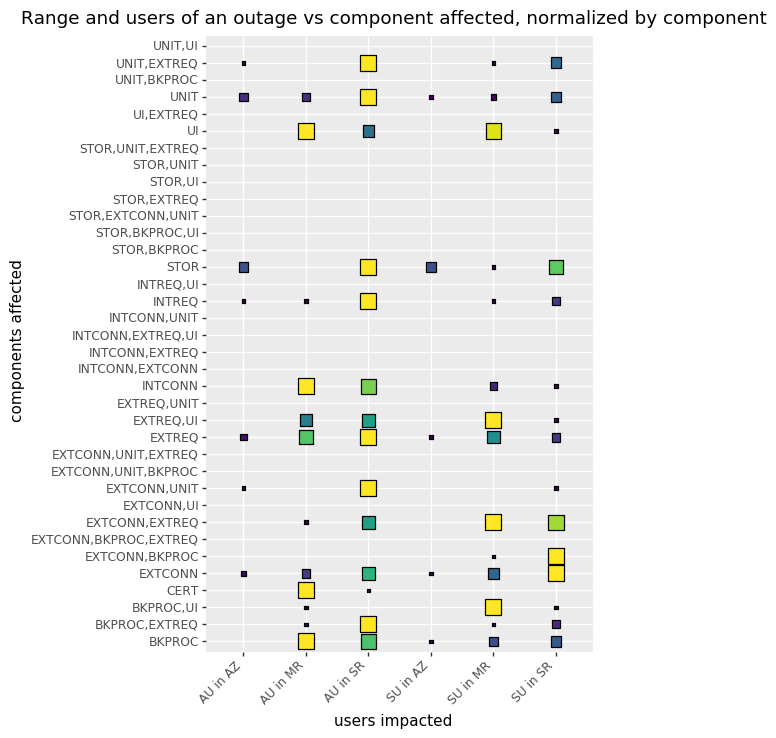

<ggplot: (316442401)>


In [15]:
filt = df[filter_notprovided(df.affected) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = (pd.DataFrame({'affected': filt.affected.map(lambda x: ','.join(map(shorten, x))), 
                       'range_users': filt.users.map(shorten)+' in '+filt.range.map(shorten), 
                       'vendor': filt.vendor})
          .pipe(count_values, groupby='range_users', countcol='affected')
          .pipe(max_normalize_by_column, by='affected', target='counts'))

export_graph("range-users-vs-component-affected", df, ['affected', 'range', 'users'],
             (p9.ggplot(plotdf)
              + p9.aes(y='affected', x='range_users', fill='counts', size='counts')
              + p9.geom_point(show_legend=False, shape='s')
              + p9.theme(figure_size=(5, 8), axis_text_x=p9.element_text(rotation=45, hjust=1))
              + p9.ggtitle("Range and users of an outage vs component affected, normalized by component")
              + p9.labs(x="users impacted", y='components affected')))

Not provided:
- cause: 605 (65.12%)
- range: 8 (0.86%)
- users: 7 (0.75%)


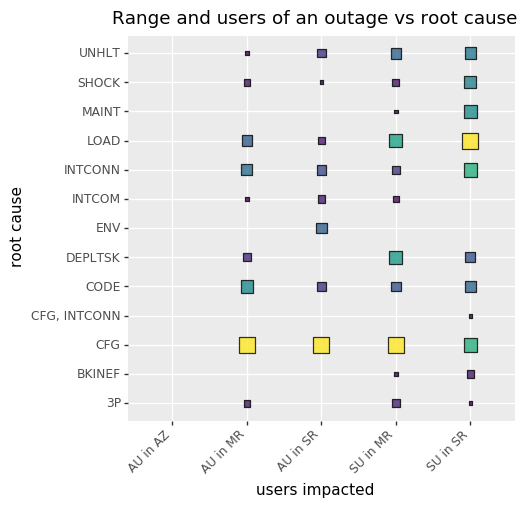

<ggplot: (316478317)>


In [16]:
filt = df[filter_notprovided(df.cause) & filter_notprovided(df.range) & filter_notprovided(df.users)]
plotdf = (pd.DataFrame({'cause': filt.cause.map(lambda x: ', '.join(map(shorten, x))), 
                       'range_users': filt.users.map(shorten)+' in '+filt.range.map(shorten)})
          .pipe(count_values, groupby='range_users', countcol='cause')
          .pipe(max_normalize_by_column, by='range_users', target='counts'))

export_graph("range-users-vs-root-cause", df, ['cause', 'range', 'users'],
             (p9.ggplot(plotdf)
              + p9.aes(x='range_users', y='cause',  fill='counts', size='counts')
              + p9.geom_point(alpha=0.8, show_legend=False, shape='s')
              + p9.theme(figure_size=(5, 5), axis_text_x=p9.element_text(rotation=45, hjust=1))
              + p9.ggtitle("Range and users of an outage vs root cause")
              + p9.labs(x='users impacted', y='root cause')))

In [17]:
# from itertools import combinations, chain
# import numpy as np

# def powerset_noempty(iterable):
#     s = list(iterable)
#     return list(filter(bool, map(list, chain.from_iterable(list(combinations(s, r)) for r in range(len(s)+1)))))

# def islist(col):
#     return col.map(type).eq(np.ndarray).all()
# def isstr(col):
#     return col.map(type).eq(str).all()

# def abbrev(s):
#     import re
#     words = s.split()
#     shortened = [re.sub('[\(\)]', '', x)[0:5] for x in words]
#     return " ".join(shortened)

# plots = []
# for pair in list(combinations(df.columns, 2)):
    
#     if isstr(df[pair[0]]) and isstr(df[pair[1]]):
#         plotpart = p9.ggplot(df, p9.aes(x=pair[0], y=pair[1]))
        
#     else:
#         # Make a temp dataframe to hold reformatted values
#         df_tmp = pd.DataFrame()
#         if islist(df[pair[0]]):
#             df_tmp[pair[0]] = df[pair[0]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[0]] = df[pair[0]]
            
#         if islist(df[pair[1]]):
#             df_tmp[pair[1]] = df[pair[1]].apply(lambda x: ','.join(map(abbrev, x)))
#         else:
#             df_tmp[pair[1]] = df[pair[1]]
        
#         plotpart = p9.ggplot(df_tmp, p9.aes(x=pair[0], y=pair[1]))

    
#     if pair[0] == 'hour_of_week':       
#         plots.append(plotpart
#                      + p9.geom_jitter()
#                      + p9.scales.xlim(0, 24*7))
#     elif pair[1] == 'hour_of_week':
#         plots.append(plotpart
#                      + p9.geom_jitter() 
#                      + p9.scales.ylim(0, 24*7))
#     else:
#         plots.append(plotpart + dsp_opt)